<div class='alert alert-block alert-info' style='font-weight: bold'>
    📌<u>Chú thích:</u> Đây là phiên bản cuối cùng để kiểm tra hiệu quả mô hình. Phương pháp đánh giá ở đây là lấy mẫu 30 phim.
</div>

<div class='alert alert-block alert-info' style='font-weight: bold'>
    <h1 style='font-size: 24px'>📌<b>Table of Contents</b></h1>
    <ol style='font-size: 20px'>
        <li>
            <a href='#library'>Import Libraries</a>
        </li>
        <li>
            <a href='#dataset'>Load Dataset</a>
            <ul style='font-size: 16px'>
                <li><a href='#data-ratings'>Ratings</a></li>
                <li><a href='#data-users'>Users Information</a></li>
                <li><a href='#data-movies'>Movies Information</a></li>
            </ul>
        </li>
        <li>
            <a href='#prepare'>Prepare Dataset</a>
        </li>
        <li>
            <a href='#model'>Model</a>
        </li>
        <li>
            <a href='#trainer'>Trainer</a>
            <ul style='font-size: 16px'>
                <li><a href='#early-stopping'>Early Stopping</a></li>
                <li><a href='#checkpoint'>Checkpoint</a></li>
                <li><a href='#epoch-trainer'>Epoch Trainer</a></li>
                <li><a href='#runner'>Hyperparameters Experiment Runner</a></li>
                <li><a href='#visualize'>Training History Visualizer</a></li>
            </ul>
        </li>
        <li>
            <a href='#training'>Process Training</a>
            <ul style='font-size: 16px'>
                <li><a href='#process-data'>Process Data</a></li>
                <li><a href='#params'>Hyperparameters</a></li>
                <li><a href='#experiments'>Experiments</a></li>
                <li><a href='#history'>Training History</a></li>
            </ul>
        </li>
        <li>
            <a href='#evaluation'>Evaluation</a>
            <ul style='font-size: 16px'>
                <li><a href='#best-model'>The Best Model</a></li>
                <li>
                    <a href='#eval-rec'>Evaluate Recommendation</a>
                    <ul>
                        <li><a href='#eval-best-model'>Through The Best Model</a></li>
                        <li><a href='#eval-embed-dims'>Through Embedding Dims</a></li>
                    </ul>
                </li>
                <li><a href='#recommend'>Process Recommendation</a></li>
            </ul>
        </li>
    </ol>
</div>

<a class='anchor' id='library'></a>
# **Import Libraries**

In [1]:
!pip install torcheval

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 3.3 MB/s eta 0:00:00a 0:00:01


In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn, optim
from torcheval.metrics.functional import binary_f1_score
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import time
import itertools
import random

<a class='anchor' id='dataset'></a>
# **Load Dataset**

In [3]:
datapath = '/kaggle/input/movielens-100k-dataset/ml-100k'

<a class='anchor' id='data-ratings'></a>
## *Ratings*

In [4]:
df_info = pd.read_csv(os.path.join(datapath, 'u.info'),
                      sep=' ',
                      header=None,
                      names=['counts', 'value'])
general_info = dict(zip(df_info['value'], df_info['counts']))
general_info

{'users': 943, 'items': 1682, 'ratings': 100000}

In [5]:
df_ratings = pd.read_csv(os.path.join(datapath, 'u.data'),
                         sep='\t',
                         header=None,
                         names=['user_id', 'movie_id', 'rating', 'timestamp'])
df_ratings

,user_id,movie_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596
...,...,...,...,...
99995,880,476,3,880175444
99996,716,204,5,879795543
99997,276,1090,1,874795795
99998,13,225,2,882399156


In [124]:
rating_counts = df_ratings['rating'].value_counts().to_frame().reset_index()
rating_counts = rating_counts.sort_values(by=['rating']).reset_index(drop=True)
rating_counts

,rating,count
0,1,6110
1,2,11370
2,3,27145
3,4,34174
4,5,21201


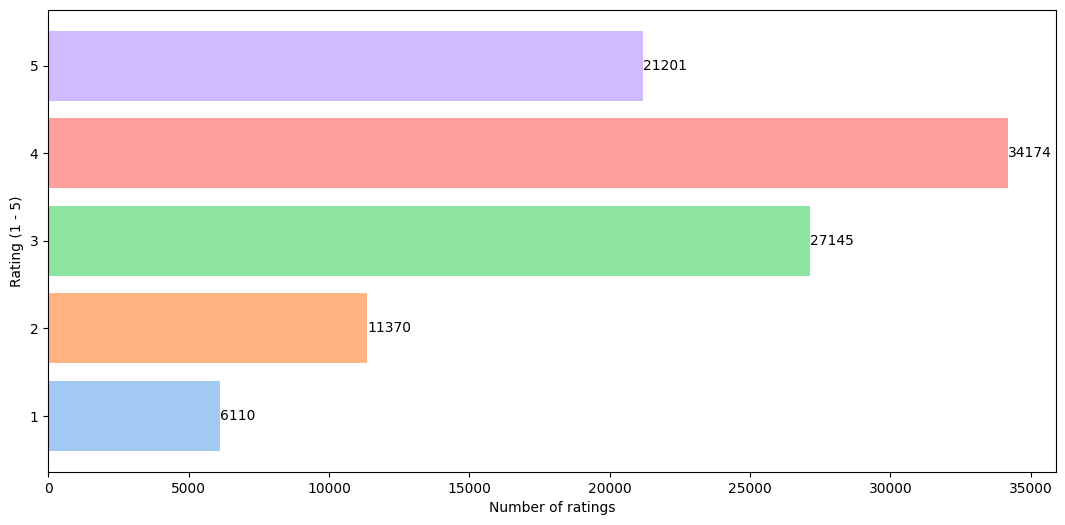

In [160]:
fig, ax = plt.subplots(figsize=(13, 6))
bars = ax.barh(rating_counts['rating'], rating_counts['count'], color=sns.color_palette('pastel'))
ax.bar_label(bars)
plt.xlabel('Number of ratings')
plt.ylabel('Rating (1 - 5)')
plt.show()

In [7]:
""" Subtract all user_id and movie_id by one since they originally start at 1 """
def subtract_id_by_one(row):
    row['user_id'] = row['user_id'] - 1
    row['movie_id'] = row['movie_id'] - 1
    return row

In [8]:
df_ratings = df_ratings.apply(subtract_id_by_one, axis=1)

<a class='anchor' id='data-users'></a>
## *Users Information*

In [9]:
df_users = pd.read_csv(os.path.join(datapath, 'u.user'),
                       sep='|',
                       header=None,
                       names=['user_id', 'age', 'gender', 'occupation', 'zip_code'])
df_users

,user_id,age,gender,occupation,zip_code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213
...,...,...,...,...,...
938,939,26,F,student,33319
939,940,32,M,administrator,02215
940,941,20,M,student,97229
941,942,48,F,librarian,78209


In [10]:
df_users['user_id'] = df_users.apply(lambda row: row['user_id'] - 1, axis=1)

In [11]:
df_occupations = pd.read_csv(os.path.join(datapath, 'u.occupation'),
                        header=None)
occupations = df_occupations[0].tolist()
print(occupations)

['administrator', 'artist', 'doctor', 'educator', 'engineer', 'entertainment', 'executive', 'healthcare', 'homemaker', 'lawyer', 'librarian', 'marketing', 'none', 'other', 'programmer', 'retired', 'salesman', 'scientist', 'student', 'technician', 'writer']


<a class='anchor' id='data-movies'></a>
## *Movies Information*

In [12]:
df_genres = pd.read_csv(os.path.join(datapath, 'u.genre'),
                        sep='|',
                        header=None,
                        usecols=[0],
                        names=['genre'])
movie_genres = df_genres['genre'].tolist()
print(movie_genres)

['unknown', 'Action', 'Adventure', 'Animation', "Children's", 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']


In [13]:
df_movies = pd.read_csv(os.path.join(datapath, 'u.item'),
                        sep='|',
                        encoding='iso-8859-1',
                        header=None,
                        usecols=[*range(0, 3)] + [*range(5, 24)],
                        names=['movie_id', 'title', 'release_date'] + movie_genres)
df_movies

,movie_id,title,release_date,unknown,Action,Adventure,Animation,Children's,Comedy,Crime,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,0,0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1677,1678,Mat' i syn (1997),06-Feb-1998,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1678,1679,B. Monkey (1998),06-Feb-1998,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
1679,1680,Sliding Doors (1998),01-Jan-1998,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1680,1681,You So Crazy (1994),01-Jan-1994,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
df_movies['movie_id'] = df_movies.apply(lambda row: row['movie_id'] - 1, axis=1)

<a class='anchor' id='prepare'></a>
# **Prepare Dataset**

<div class='alert alert-block alert-info' style='font-weight: bold'>
    The original range of ratings is from 1 to 5 (integer type). This kind of data is seen as explicit and also hard to be collected in real life due to lack of interest of users. Within the scope of this project, we want to process implicit data for the purpose of building movie recommender instead of predicting lacking ratings. Consequently, every rating which is strictly greater than 3 will be converted to 1, otherwise 0.
</div>

In [15]:
class RatingsDataset(Dataset):
    
    def __init__(self, data_ratings):
        self.user_ids = data_ratings['user_id'].values
        self.movie_ids = data_ratings['movie_id'].values
        self.ratings = data_ratings['rating'].apply(lambda r: 1 if r > 3 else 0).values

    def __getitem__(self, idx):
        user_id = torch.tensor(self.user_ids[idx], dtype=torch.long)
        movie_id = torch.tensor(self.movie_ids[idx], dtype=torch.long)
        rating = torch.tensor(self.ratings[idx], dtype=torch.float)
        return user_id, movie_id, rating

    def __len__(self):
        return len(self.ratings)

In [16]:
def prepare_data(data, eval_indices, split_ratio, n_unrated_samples=10):
    
    for user_id in range(general_info['users']):
        rated_movies = data[data['user_id'] == user_id]['movie_id'].tolist()
        unrated_movies = list(set(range(general_info['items'])) - set(rated_movies))
        sample_unrated_movies = random.sample(unrated_movies, n_unrated_samples)
        data_unrated = pd.DataFrame({
            'user_id': [user_id] * n_unrated_samples,
            'movie_id': sample_unrated_movies,
            'rating': [0] * n_unrated_samples
        })
        data = pd.concat([data, data_unrated])
    
    data = data.drop(eval_indices)
    
    train_end = int(len(data) * split_ratio[0])
    val_end = train_end + int(len(data) * split_ratio[1])
    
    train_set = RatingsDataset(data.iloc[:train_end])
    val_set = RatingsDataset(data.iloc[train_end:val_end])
    test_set = RatingsDataset(data.iloc[val_end:])
    
    return train_set, val_set, test_set

<div class='alert alert-block alert-info' style='font-weight: bold'>
    For the rearmost evaluating phase, we pick the latest rating activity of each user. Detailed method will be explained later.
</div>

In [17]:
def prepare_eval_data(data):
    eval_data = []
    eval_indices = []
    missing_positive_rating = []
    
    for i in range(general_info['users']):
        df_user = df_ratings[(df_ratings['user_id'] == i) & (df_ratings['rating'] > 3)]
        if len(df_user > 0):
            df_user = df_user.sort_values(by=['timestamp'], ascending=False)
            eval_data.append({
                'user_id': df_user.iloc[0]['user_id'],
                'movie_id': df_user.iloc[0]['movie_id'],
                'rating': df_user.iloc[0]['rating']
            })
            eval_indices.append(df_user.index[0])
        else:
            missing_positive_rating.append(i)
    return eval_data, eval_indices, missing_positive_rating

<a class='anchor' id='model'></a>
# **Model**

<div style='text-align: center'>
    <img src='https://cdn.prod.website-files.com/5fdc17d51dc102ed1cf87c05/608703d9519acaa7bca8e92e_ncf.png' width='50%'>
    <br>
    <b>Neural Matrix Factorization Model (GMF + NCF)</b>
</div>

In [18]:
class MovieRecommender(nn.Module):

    def __init__(self, n_users, n_movies, embedding_dim, hidden_dims, dropout):
        super(MovieRecommender, self).__init__()
        
        self.user_embedding = nn.Embedding(n_users, embedding_dim)
        self.movie_embedding = nn.Embedding(n_movies, embedding_dim)
        
        hidden_layers = []
        in_dim = embedding_dim * 2
        for hid_dim in hidden_dims:
            hidden_layers.append(nn.Linear(in_dim, hid_dim))
            hidden_layers.append(nn.BatchNorm1d(hid_dim))
            hidden_layers.append(nn.ReLU())
            hidden_layers.append(nn.Dropout(p=dropout))
            in_dim = hid_dim
        self.mlp = nn.Sequential(*hidden_layers)
        
        self.out = nn.Linear(embedding_dim + hidden_dims[-1], 1)
        
        for module in self.modules():
            if isinstance(module, (nn.Embedding, nn.Linear)):
                torch.nn.init.normal_(module.weight.data, 0.0, 0.01)

    def forward(self, user_id, movie_id):
        
        # Generalized Matrix Factorization
        gmf_u_embed = self.user_embedding(user_id)
        gmf_m_embed = self.movie_embedding(movie_id)
        
        gmf_layer = gmf_u_embed * gmf_m_embed
        
        # Multi-Layer Perception
        mlp_u_embed = self.user_embedding(user_id)
        mlp_m_embed = self.movie_embedding(movie_id)
        
        mlp_inputs = torch.cat((mlp_u_embed, mlp_m_embed), -1)
        mlp_layer = self.mlp(mlp_inputs)
        
        # Neural Matrix Factorization
        neumf_layer = torch.cat((gmf_layer, mlp_layer), -1)
        output = F.sigmoid(self.out(neumf_layer)).squeeze()
        return output

<a class='anchor' id='trainer'></a>
# **Trainer**

<a class='anchor' id='early-stopping'></a>
## *Early Stopping*

In [19]:
class EarlyStopping:
    def __init__(self, min_delta=0, patience=5):
        self.min_delta = min_delta
        self.patience = patience
        self.counter = 0
        self.prev_val_loss = float('inf')
        self.early_stop = False

    def __call__(self, val_loss):
        if self.prev_val_loss - val_loss <= self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.counter = 0
            self.prev_val_loss = val_loss

<a class='anchor' id='checkpoint'></a>
## *Checkpoint*

In [20]:
class Checkpoint:
    def __init__(self):
        self.prev_val_loss = float('inf')
        self.better_model = False
        
    def __call__(self, val_loss):
        if val_loss < self.prev_val_loss:
            self.better_model = True
            self.prev_val_loss = val_loss
            
    def save(self, filename, epoch, model, optimizer, train_loss, val_loss, config_params):
        if self.better_model:
            print('Saving checkpoint...')
            try:
                checkpoint = {
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'train_loss': train_loss,
                    'val_loss': val_loss
                }
                checkpoint.update(config_params)
                torch.save(checkpoint, filename)
                print('=> Successfully saved checkpoint!')
                self.better_model = False
            except:
                print('=> Failed to save checkpoint!')
        else:
            print('=> This model state is not better than previous one!')
        
    def load(filename, model, optimizer):
        print('Loading checkpoint...')
        try:
            checkpoint = torch.load(filename)
            model.load_state_dict(checkpoint['state_dict'])
            optimizer.load_state_dict(checkpoint['optimizer'])
            print('=> Successfully loaded checkpoint!')
            checkpoint_info = {
                'epoch': checkpoint['epoch'],
                'train_loss': checkpoint['train_loss'],
                'val_loss': checkpoint['val_loss'],
                'batch_size': checkpoint['batch_size'],
                'drop_out': checkpoint['drop_out'],
                'embedding_dim': checkpoint['embedding_dim'],
                'learning_rate': checkpoint['learning_rate'],
                'num_hiddens': checkpoint['num_hiddens'],
                'weight_decay': checkpoint['weight_decay']
            }
            return model, optimizer, checkpoint_info
        except:
            print('=> Failed to load checkpoint!')
            return None

<a class='anchor' id='epoch-trainer'></a>
## *Epoch Trainer*

In [21]:
def train_model(model, device, train_loader, val_loader, optimizer, criteria, epochs, config_params, model_name):
    
    model.to(device)

    train_losses = []
    train_f1s = []
    val_losses = []
    val_f1s = []

    start_time = time.time()
    
    early_stopping = EarlyStopping(min_delta=2e-4, patience=3)
    checkpoint = Checkpoint()
    
    trained_epochs = 0

    for epoch in range(epochs):
        print(f'=== EPOCH {epoch + 1}/{epochs} ===')

        """ TRAINING PHASE """
        model.train()
        train_loss = 0.0
        train_f1 = 0.0

        progress_bar = tqdm(enumerate(train_loader), total=len(train_loader))
        for i, (batch_user_ids, batch_movie_ids, batch_ratings) in progress_bar:
            batch_user_ids = batch_user_ids.to(device)
            batch_movie_ids = batch_movie_ids.to(device)
            batch_ratings = batch_ratings.to(device)
            
            optimizer.zero_grad()
            outputs = model(batch_user_ids, batch_movie_ids)
            loss = criteria(outputs, batch_ratings)
            loss.backward()
            optimizer.step()

            train_loss = train_loss + loss.item() * batch_user_ids.size(0)
            train_f1 = train_f1 + binary_f1_score(outputs, batch_ratings) * batch_user_ids.size(0)

        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)
        train_f1 /= len(train_loader.dataset)
        train_f1s.append(train_f1)

        """ VALIDATION PHASE """
        model.eval()
        val_loss = 0.0
        val_f1 = 0.0

        with torch.no_grad():
            progress_bar = tqdm(enumerate(val_loader), total=len(val_loader))
            for i, (batch_user_ids, batch_movie_ids, batch_ratings) in progress_bar:
                batch_user_ids = batch_user_ids.to(device)
                batch_movie_ids = batch_movie_ids.to(device)
                batch_ratings = batch_ratings.to(device)

                outputs = model(batch_user_ids, batch_movie_ids)
                loss = criteria(outputs, batch_ratings)
                
                val_loss = val_loss + loss.item() * batch_user_ids.size(0)
                val_f1 = val_f1 + binary_f1_score(outputs, batch_ratings) * batch_user_ids.size(0)

        val_loss /= len(val_loader.dataset)
        val_losses.append(val_loss)
        val_f1 /= len(val_loader.dataset)
        val_f1s.append(val_f1)

        print(f'+ Training Loss: {train_loss:.4f}, ',
              f'+ Training F1 Score: {train_f1:.4f}, '
              f'+ Validation Loss: {val_loss:.4f}, ',
              f'+ Validation F1 Score: {val_f1:.4f}'
             )
        
        """ SAVING CHECKPOINT """
        checkpoint(val_loss)
        checkpoint.save(model_name, epoch, model, optimizer, train_loss, val_loss, config_params)
            
        """ EARLY STOPPING """
        trained_epochs = epoch + 1
        early_stopping(val_loss)
        if early_stopping.early_stop:
            print(f'== We are at epoch {epoch + 1} ==')
            break

    history = {
        'train_losses': train_losses,
        'train_f1s': train_f1s,
        'val_losses': val_losses,
        'val_f1s': val_f1s
    }

    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f'\nTraining complete in {elapsed_time // 60:.0f}m {elapsed_time % 60:.0f}s')

    return model, history, trained_epochs

<a class='anchor' id='runner'></a>
## *Hyperparameters Experiment Runner*

<div class='alert alert-block alert-info' style='font-weight: bold'>
    The last hidden dim of MLP block is assigned with the same value as embedding dim of user & movie latent vectors.
    With the given number of hidden layers, each layer will be in double size of its next layer.
</div>

In [22]:
def running(epochs, params, idx, model_name):
    
    """ Unpack tuple of hyperparameters """
    (batch_size, dropout, embedding_dim, learning_rate, num_hiddens, weight_decay) = params
    print(f'\n#{idx} === HYPERPARAMETERS ===')
    print(f'batch size: {batch_size} - drop out: {dropout} - embedding dim: {embedding_dim} ' +
          f'- learning rate: {learning_rate} - num hiddens: {num_hiddens} - weight decay: {weight_decay}\n')
    
    """ DATA LOADER """
    train_loader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(dataset=val_set, batch_size=batch_size, shuffle=True)
    
    """ Generate configuration of hidden dims based on embedding dims """
    hidden_dims = [0] * num_hiddens
    for i in range(num_hiddens):
        hidden_dims[i] = embedding_dim * (2 ** (num_hiddens - i - 1))
    
    """ INITIALIZE MODEL """
    model = MovieRecommender(n_users=general_info['users'],
                             n_movies=general_info['items'],
                             embedding_dim=embedding_dim,
                             hidden_dims=hidden_dims,
                             dropout=dropout)
    optimizer = optim.Adam(params=model.parameters(),
                           lr=learning_rate,
                           weight_decay=weight_decay)
    criteria = nn.BCELoss()
    
    config_params = {
        'batch_size': batch_size,
        'drop_out': dropout,
        'embedding_dim': embedding_dim,
        'learning_rate': learning_rate,
        'num_hiddens': num_hiddens,
        'weight_decay': weight_decay
    }
    
    """ PROCESS TRAINING """
    model_name = f'{model_name}-{idx}.pth'
    trained_model, history, trained_epochs = train_model(model, device, train_loader, val_loader,
                                                         optimizer, criteria, epochs, config_params, model_name)
    return trained_model, history, trained_epochs

<a class='anchor' id='visualize'></a>
## *Training History Visualizer*

In [23]:
def visualize_training(history, params):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
    ax1.plot(history['train_losses'], label='train_losses')
    ax1.plot(history['val_losses'], label='val_losses')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.grid(True)

    ax2.plot(history['train_f1s'], label='train_f1s')
    ax2.plot(history['val_f1s'], label='val_f1s')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('F1 Score')
    ax2.grid(True)
        
    plt.show()
    
    (batch_size, dropout, embedding_dim, learning_rate, num_hiddens, weight_decay) = params
    print('=' * 60)
    print(f'batch size: {batch_size} - dropout: {dropout} - embedding dim: {embedding_dim} ' +
          f'- learning rate: {learning_rate} - num hiddens: {num_hiddens} - weight decay: {weight_decay}')
    print('=' * 60)
    print()

    return

<a class='anchor' id='training'></a>
# **Process Training**

In [24]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Training device: {device}')

Training device: cpu


<a class='anchor' id='process-data'></a>
## *Process Data*

In [25]:
eval_data, eval_indices, missing_positive_rating = prepare_eval_data(df_ratings)

print(f"Users who haven't rated any positive ratings (> 3): {missing_positive_rating}")
print(f'Total number of users for evaluating recommendation: {len(eval_indices)}')

Users who haven't rated any positive ratings (> 3): [684]
Total number of users for evaluating recommendation: 942


In [26]:
train_set, val_set, test_set = prepare_data(df_ratings, eval_indices, split_ratio=[0.8, 0.1, 0.1], n_unrated_samples=10)

print(f'Training size: {len(train_set)}')
print(f'Validation size: {len(val_set)}')
print(f'Test size: {len(test_set)}')

Training size: 86790
Validation size: 10848
Test size: 10850


In [ ]:
set_labels = ['Training', 'Validation', 'Test']

In [103]:
label_1_counts = [sum(train_set.ratings), sum(val_set.ratings), sum(test_set.ratings)]
label_0_counts = [len(train_set) - label_1_counts[0], len(val_set) - label_1_counts[1], len(test_set) - label_1_counts[2]]
print(f'Label #1 counts: {label_1_counts}')
print(f'Label #0 counts: {label_0_counts}')

Label #1 counts: [47807, 5857, 769]
Label #0 counts: [38983, 4991, 10081]


<Axes: >

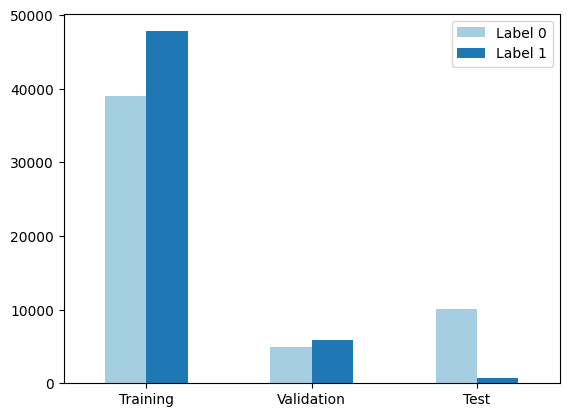

In [110]:
pd.DataFrame({'Label 0': label_0_counts, 'Label 1': label_1_counts},
            index=set_labels).plot.bar(color=sns.color_palette('Paired'), rot=0)

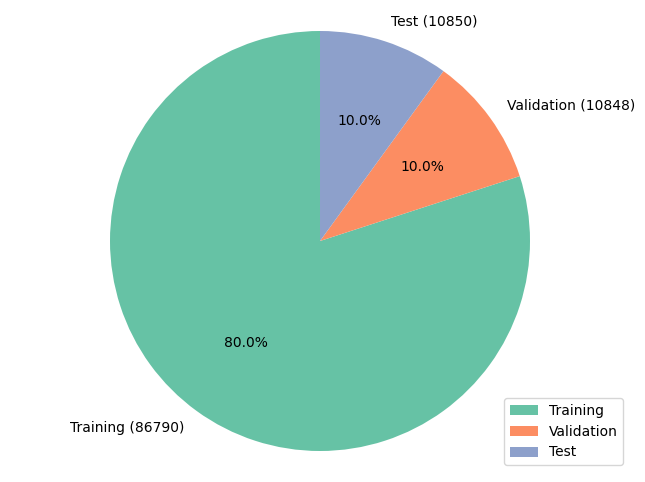

In [57]:
dataset_split_counts = [len(train_set), len(val_set), len(test_set)]

plt.figure(figsize=(8, 6))
plt.pie(dataset_split_counts,
        labels=[' '.join([label, f'({str(dataset_split_counts[i])})']) for i, label in enumerate(set_labels)],
        autopct='%.1f%%',
        colors=sns.color_palette('Set2'),
        startangle=90)
plt.legend(set_labels, loc='lower right')
plt.axis('equal')
plt.show()

<a class='anchor' id='params'></a>
## *Hyperparameters*

In [28]:
batch_sizes = [512]
dropouts = [0.5]
embedding_dims = [8, 16, 32]
epochs = 100
learning_rates = [1e-3]
nums_hiddens = [4]
weights_decay = [1e-6]
model_name = 'movie-recommender'

In [29]:
hyperparameters = list(itertools.product(batch_sizes, dropouts, embedding_dims, learning_rates, nums_hiddens, weights_decay))

In [30]:
i = 1
for params in hyperparameters:
    print(f'{i} - {params}')
    i += 1

1 - (512, 0.5, 8, 0.001, 4, 1e-06)
2 - (512, 0.5, 16, 0.001, 4, 1e-06)
3 - (512, 0.5, 32, 0.001, 4, 1e-06)


<a class='anchor' id='experiments'></a>
## *Experiments*

In [31]:
model_idx = 1
models = []
histories = []
all_trained_epochs = []

In [32]:
for params in hyperparameters:
    model, history, trained_epochs = running(epochs, params, model_idx, model_name)
    models.append(model)
    histories.append(history)
    all_trained_epochs.append(trained_epochs)
    model_idx += 1


#1 === HYPERPARAMETERS ===
batch size: 512 - drop out: 0.5 - embedding dim: 8 - learning rate: 0.001 - num hiddens: 4 - weight decay: 1e-06

=== EPOCH 1/100 ===


100%|██████████| 22/22 [00:00<00:00, 78.43it/s]


+ Training Loss: 0.6687,  + Training F1 Score: 0.6896, + Validation Loss: 0.6374,  + Validation F1 Score: 0.7009
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 2/100 ===


100%|██████████| 22/22 [00:00<00:00, 76.73it/s]


+ Training Loss: 0.6298,  + Training F1 Score: 0.6851, + Validation Loss: 0.6192,  + Validation F1 Score: 0.6778
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 3/100 ===


100%|██████████| 22/22 [00:00<00:00, 76.60it/s]


+ Training Loss: 0.6161,  + Training F1 Score: 0.7024, + Validation Loss: 0.6100,  + Validation F1 Score: 0.6865
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 4/100 ===


100%|██████████| 22/22 [00:00<00:00, 77.48it/s]


+ Training Loss: 0.6082,  + Training F1 Score: 0.7116, + Validation Loss: 0.6032,  + Validation F1 Score: 0.6954
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 5/100 ===


100%|██████████| 22/22 [00:00<00:00, 77.62it/s]


+ Training Loss: 0.6009,  + Training F1 Score: 0.7161, + Validation Loss: 0.6003,  + Validation F1 Score: 0.7049
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 6/100 ===


100%|██████████| 22/22 [00:00<00:00, 71.01it/s]


+ Training Loss: 0.5974,  + Training F1 Score: 0.7183, + Validation Loss: 0.5972,  + Validation F1 Score: 0.7148
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 7/100 ===


100%|██████████| 22/22 [00:00<00:00, 77.08it/s]


+ Training Loss: 0.5948,  + Training F1 Score: 0.7243, + Validation Loss: 0.5949,  + Validation F1 Score: 0.7140
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 8/100 ===


100%|██████████| 22/22 [00:00<00:00, 75.78it/s]


+ Training Loss: 0.5909,  + Training F1 Score: 0.7263, + Validation Loss: 0.5917,  + Validation F1 Score: 0.7202
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 9/100 ===


100%|██████████| 22/22 [00:00<00:00, 79.71it/s]


+ Training Loss: 0.5858,  + Training F1 Score: 0.7303, + Validation Loss: 0.5926,  + Validation F1 Score: 0.7224
=> This model state is not better than previous one!
=== EPOCH 10/100 ===


100%|██████████| 22/22 [00:00<00:00, 78.06it/s]


+ Training Loss: 0.5836,  + Training F1 Score: 0.7311, + Validation Loss: 0.5927,  + Validation F1 Score: 0.7156
=> This model state is not better than previous one!
=== EPOCH 11/100 ===


100%|██████████| 22/22 [00:00<00:00, 65.18it/s]


+ Training Loss: 0.5804,  + Training F1 Score: 0.7335, + Validation Loss: 0.5922,  + Validation F1 Score: 0.7230
=> This model state is not better than previous one!
== We are at epoch 11 ==

Training complete in 0m 37s

#2 === HYPERPARAMETERS ===
batch size: 512 - drop out: 0.5 - embedding dim: 16 - learning rate: 0.001 - num hiddens: 4 - weight decay: 1e-06

=== EPOCH 1/100 ===


100%|██████████| 22/22 [00:00<00:00, 74.99it/s]


+ Training Loss: 0.6462,  + Training F1 Score: 0.7237, + Validation Loss: 0.5848,  + Validation F1 Score: 0.7350
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 2/100 ===


100%|██████████| 22/22 [00:00<00:00, 77.71it/s]


+ Training Loss: 0.5821,  + Training F1 Score: 0.7509, + Validation Loss: 0.5672,  + Validation F1 Score: 0.7439
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 3/100 ===


100%|██████████| 22/22 [00:00<00:00, 73.69it/s]


+ Training Loss: 0.5676,  + Training F1 Score: 0.7597, + Validation Loss: 0.5637,  + Validation F1 Score: 0.7504
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 4/100 ===


100%|██████████| 22/22 [00:00<00:00, 75.17it/s]


+ Training Loss: 0.5592,  + Training F1 Score: 0.7626, + Validation Loss: 0.5612,  + Validation F1 Score: 0.7469
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 5/100 ===


100%|██████████| 22/22 [00:00<00:00, 67.09it/s]


+ Training Loss: 0.5560,  + Training F1 Score: 0.7601, + Validation Loss: 0.5616,  + Validation F1 Score: 0.7448
=> This model state is not better than previous one!
=== EPOCH 6/100 ===


100%|██████████| 22/22 [00:00<00:00, 76.89it/s]


+ Training Loss: 0.5498,  + Training F1 Score: 0.7629, + Validation Loss: 0.5623,  + Validation F1 Score: 0.7398
=> This model state is not better than previous one!
=== EPOCH 7/100 ===


100%|██████████| 22/22 [00:00<00:00, 47.12it/s]


+ Training Loss: 0.5453,  + Training F1 Score: 0.7644, + Validation Loss: 0.5615,  + Validation F1 Score: 0.7430
=> This model state is not better than previous one!
== We are at epoch 7 ==

Training complete in 0m 25s

#3 === HYPERPARAMETERS ===
batch size: 512 - drop out: 0.5 - embedding dim: 32 - learning rate: 0.001 - num hiddens: 4 - weight decay: 1e-06

=== EPOCH 1/100 ===


100%|██████████| 22/22 [00:00<00:00, 72.06it/s]


+ Training Loss: 0.6356,  + Training F1 Score: 0.6885, + Validation Loss: 0.5970,  + Validation F1 Score: 0.7397
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 2/100 ===


100%|██████████| 22/22 [00:00<00:00, 72.52it/s]


+ Training Loss: 0.5826,  + Training F1 Score: 0.7424, + Validation Loss: 0.5744,  + Validation F1 Score: 0.7349
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 3/100 ===


100%|██████████| 22/22 [00:00<00:00, 70.55it/s]


+ Training Loss: 0.5668,  + Training F1 Score: 0.7547, + Validation Loss: 0.5673,  + Validation F1 Score: 0.7346
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 4/100 ===


100%|██████████| 22/22 [00:00<00:00, 71.97it/s]


+ Training Loss: 0.5590,  + Training F1 Score: 0.7591, + Validation Loss: 0.5641,  + Validation F1 Score: 0.7314
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 5/100 ===


100%|██████████| 22/22 [00:00<00:00, 70.32it/s]


+ Training Loss: 0.5515,  + Training F1 Score: 0.7626, + Validation Loss: 0.5642,  + Validation F1 Score: 0.7346
=> This model state is not better than previous one!
=== EPOCH 6/100 ===


100%|██████████| 22/22 [00:00<00:00, 71.71it/s]


+ Training Loss: 0.5416,  + Training F1 Score: 0.7663, + Validation Loss: 0.5646,  + Validation F1 Score: 0.7383
=> This model state is not better than previous one!
=== EPOCH 7/100 ===


100%|██████████| 22/22 [00:00<00:00, 73.22it/s]


+ Training Loss: 0.5344,  + Training F1 Score: 0.7718, + Validation Loss: 0.5630,  + Validation F1 Score: 0.7360
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 8/100 ===


100%|██████████| 22/22 [00:00<00:00, 44.94it/s]


+ Training Loss: 0.5258,  + Training F1 Score: 0.7781, + Validation Loss: 0.5617,  + Validation F1 Score: 0.7350
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 9/100 ===


100%|██████████| 22/22 [00:00<00:00, 68.97it/s]


+ Training Loss: 0.5193,  + Training F1 Score: 0.7827, + Validation Loss: 0.5652,  + Validation F1 Score: 0.7381
=> This model state is not better than previous one!
=== EPOCH 10/100 ===


100%|██████████| 22/22 [00:00<00:00, 71.28it/s]


+ Training Loss: 0.5126,  + Training F1 Score: 0.7868, + Validation Loss: 0.5687,  + Validation F1 Score: 0.7332
=> This model state is not better than previous one!
=== EPOCH 11/100 ===


100%|██████████| 22/22 [00:00<00:00, 71.63it/s]

+ Training Loss: 0.5059,  + Training F1 Score: 0.7918, + Validation Loss: 0.5673,  + Validation F1 Score: 0.7387
=> This model state is not better than previous one!
== We are at epoch 11 ==

Training complete in 0m 44s


<a class='anchor' id='history'></a>
## *Training History*

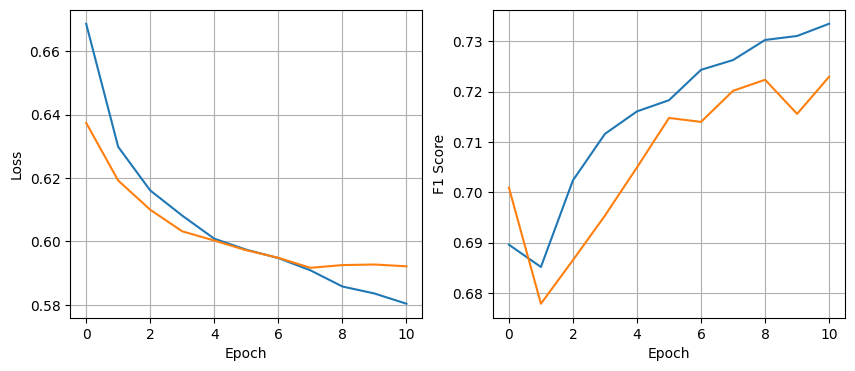

batch size: 512 - dropout: 0.5 - embedding dim: 8 - learning rate: 0.001 - num hiddens: 4 - weight decay: 1e-06



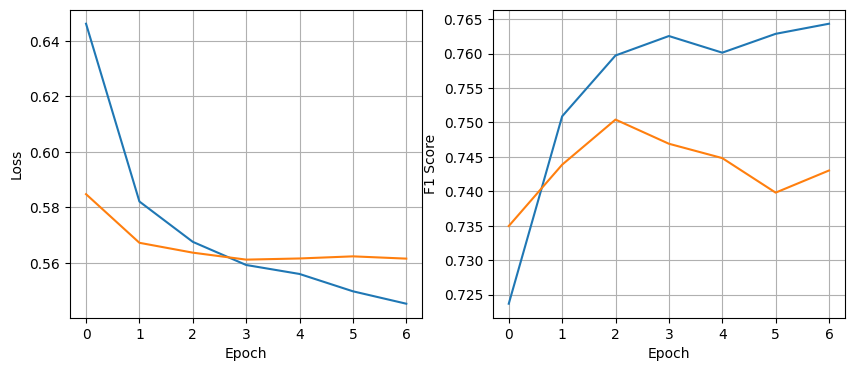

batch size: 512 - dropout: 0.5 - embedding dim: 16 - learning rate: 0.001 - num hiddens: 4 - weight decay: 1e-06



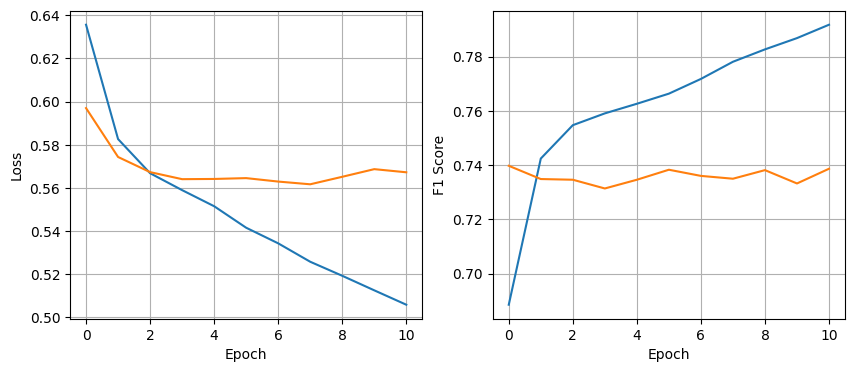

batch size: 512 - dropout: 0.5 - embedding dim: 32 - learning rate: 0.001 - num hiddens: 4 - weight decay: 1e-06



In [33]:
for i, params in enumerate(hyperparameters):
    visualize_training(histories[i], params)

<a class='anchor' id='evaluation'></a>
# **Evaluation**

<a class='anchor' id='best-model'></a>
## *The Best Model*

In [35]:
def test_model(model, device, test_loader, criteria):
    model.to(device)    
    model.eval()
    test_loss = 0.0
    
    with torch.no_grad():
        progress_bar = tqdm(enumerate(test_loader), total=len(test_loader))
        for i, (batch_user_ids, batch_movie_ids, batch_ratings) in progress_bar:
            batch_user_ids = batch_user_ids.to(device)
            batch_movie_ids = batch_movie_ids.to(device)
            batch_ratings = batch_ratings.to(device)

            outputs = model(batch_user_ids, batch_movie_ids)
            loss = criteria(outputs, batch_ratings)
                
            test_loss = test_loss + loss.item() * batch_user_ids.size(0)

    test_loss /= len(test_loader.dataset)
    return test_loss

In [36]:
""" Test all experimental models """
test_losses = []
for i, model in enumerate(models):
    batch_size = hyperparameters[i][0]
    test_loader = DataLoader(dataset=test_set, batch_size=batch_size, shuffle=True)
    test_loss = test_model(model, device, test_loader, nn.BCELoss())
    test_losses.append((i + 1, test_loss))

100%|██████████| 22/22 [00:00<00:00, 73.01it/s]


In [37]:
""" Sort test losses of all experimental models """
test_losses = sorted(test_losses, key=lambda item: item[1])
for test_loss in test_losses:
    print(f'{test_loss}  \t{hyperparameters[test_loss[0] - 1]}')

(2, 0.7529285617467995)  	(512, 0.5, 16, 0.001, 4, 1e-06)
(3, 0.859984052576777)  	(512, 0.5, 32, 0.001, 4, 1e-06)
(1, 0.8996769315855844)  	(512, 0.5, 8, 0.001, 4, 1e-06)


In [38]:
def construct_model_dict(idx):
    model_dict = {
        'idx': idx,
        'model': models[idx - 1],
        'history': histories[idx - 1],
        'params': hyperparameters[idx - 1]
    }
    return model_dict

=== The Best Model ===
# Index: 2
----------------------
# Architecture:
MovieRecommender(
  (user_embedding): Embedding(943, 16)
  (movie_embedding): Embedding(1682, 16)
  (mlp): Sequential(
    (0): Linear(in_features=32, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.5, inplace=False)
    (8): Linear(in_features=64, out_features=32, bias=True)
    (9): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.5, inplace=False)
    (12): Linear(in_features=32, out_features=16, bias=True)
    (13): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
    (15): Dropout(p=0.5

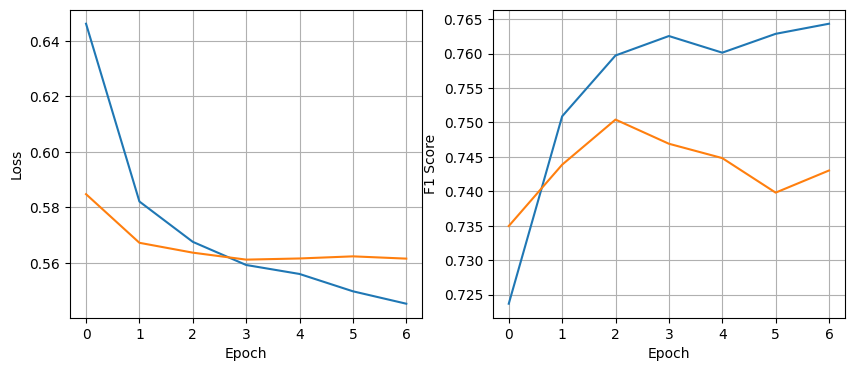

batch size: 512 - dropout: 0.5 - embedding dim: 16 - learning rate: 0.001 - num hiddens: 4 - weight decay: 1e-06



In [39]:
""" Get the model with the lowest loss """
top_idx = test_losses[0][0]
best_model = construct_model_dict(top_idx)
print('=== The Best Model ===')
print(f"# Index: {best_model['idx']}")
print('-' * 22)
print(f"# Architecture:\n{best_model['model']}\n")
visualize_training(best_model['history'], best_model['params'])

<a class='anchor' id='eval-rec'></a>
## *Evaluate Recommendation*

<div class='alert alert-block alert-info' style='font-weight: bold'>
    For each user, we will get a sample of <i>n</i> movies (predefined size) from all the movies that haven't rated by that user. Together with the movie rating generated before for evaluating, a list of <i>n + 1</i> will be fed into the recommendation model. The result of relevant scores between that user and the mentioned list of movies will be used to evaluate model performance through 2 metrics: HR@k and nDCG@k.
</div>

In [40]:
""" Generate a list of <n_samples> unrated movies """
def generate_eval_samples(eval_data, data_ratings, n_samples=100):
    for user in eval_data:
        rated_movies = data_ratings[data_ratings['user_id'] == user['user_id']]['movie_id'].tolist()
        unrated_movies = list(set(range(general_info['items'])) - set(rated_movies))
        sample_unrated_movies = random.sample(unrated_movies, n_samples)
        user['unrated_movies'] = sample_unrated_movies
    return eval_data

In [41]:
def predict_relevant_scores(model, user_id, movie_ids): # one user - all movies
    
    user_ids = torch.tensor([user_id] * len(movie_ids), dtype=torch.long)
    movie_ids = torch.tensor(movie_ids, dtype=torch.long)
    
    with torch.no_grad():
        user_ids = user_ids.to(device)
        movie_ids = movie_ids.to(device)
        outputs = model(user_ids, movie_ids)
        
    return outputs

In [42]:
def evaluate_recommendation(model, eval_data, data_ratings, k_values):
    
    hrs_at_k = [0.0] * len(k_values)
    ndcgs_at_k = [0.0] * len(k_values)
    
    for user in eval_data:
        """ Predict relevant scores """
        rel_scores = predict_relevant_scores(model, user['user_id'], [user['movie_id']] + user['unrated_movies'])
        rel_scores = zip(range(len(rel_scores)), rel_scores)
        rel_scores = sorted(rel_scores, key=lambda item: item[1], reverse=True)
        
        """ Evaluate through each top-k list """
        for k_idx, k in enumerate(k_values):
            top_k = rel_scores[:k]

            for i in range(k):
                if top_k[i][0] == 0:                
                    """ Calculate HR@k """
                    hrs_at_k[k_idx] += 1

                    """ Calculate nDCG@k """
                    ndcgs_at_k[k_idx] += (torch.log(torch.tensor(2)) / torch.log(torch.tensor(i + 2))).item()
                    break
    
    for i in range(len(k_values)):
        hrs_at_k[i] /= len(eval_data)
        ndcgs_at_k[i] /= len(eval_data)
    
    return hrs_at_k, ndcgs_at_k

In [43]:
markers = ['o', 's', '^', '*', 'P', 'X']
lines = ['-', ':', '--', '-.']
colors = ['r', 'g', 'b', 'c', 'm', 'y']

def format_plot_style(markers, lines, colors, n_plots):
    rand_m = random.sample(markers, n_plots)
    rand_l = random.sample(lines, n_plots)
    rand_c = random.sample(colors, n_plots)
    return [''.join([rand_m[i], rand_l[i], rand_c[i]]) for i in range(n_plots)]

def visualize_eval_metrics(all_hrs_at_k, all_ndcgs_at_k, labels, num_k, params):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

    hr_plot_styles = format_plot_style(markers, lines, colors, len(all_hrs_at_k))
    hr_lines = []
    for i, hrs_at_k in enumerate(all_hrs_at_k):
        line, = ax1.plot(hrs_at_k, hr_plot_styles[i])
        hr_lines.append(line)
    ax1.legend(handles=hr_lines, labels=labels)
    ax1.set_xlabel('k')
    ax1.set_ylabel('HR@k')
    ax1.set_xticks(list(range(num_k)), list(range(1, num_k + 1)))
    ax1.grid(True)

    ndcg_plot_styles = format_plot_style(markers, lines, colors, len(all_ndcgs_at_k))
    ndcg_lines = []
    for i, ndcgs_at_k in enumerate(all_ndcgs_at_k):
        line, = ax2.plot(ndcgs_at_k, ndcg_plot_styles[i])
        ndcg_lines.append(line)
    ax2.legend(handles=ndcg_lines, labels=labels)
    ax2.set_xlabel('k')
    ax2.set_ylabel('nDCG@k')
    ax2.set_xticks(list(range(num_k)), list(range(1, num_k + 1)))
    ax2.grid(True)

    plt.show()
    
    (batch_size, dropout, embedding_dim, learning_rate, num_hiddens, weight_decay) = params
    print('=' * 60)
    print(f'batch size: {batch_size} - dropout: {dropout} - embedding dim: {embedding_dim} ' +
          f'- learning rate: {learning_rate} - num hiddens: {num_hiddens} - weight decay: {weight_decay}')
    print('=' * 60)

In [44]:
def display_eval_metrics(all_hrs_at_k, all_ndcgs_at_k, model_names, k_values):
    metric_names = ['HR@k', 'nDCG@k']
    multi_idx = pd.MultiIndex.from_product([model_names, metric_names])
    
    m_table = []
    for i in range(len(model_names)):
        m_table.append(all_hrs_at_k[i])
        m_table.append(all_ndcgs_at_k[i])
    return pd.DataFrame(m_table, index=multi_idx, columns=k_values)

In [120]:
n_samples = 30
k_values = list(range(1, 11))

In [121]:
sample_eval_data = generate_eval_samples(eval_data, df_ratings, n_samples)
print(sample_eval_data[0])

{'user_id': 0, 'movie_id': 255, 'rating': 4, 'unrated_movies': [491, 1681, 416, 679, 1365, 544, 1270, 1095, 859, 487, 1083, 1105, 1419, 936, 602, 1228, 1533, 1447, 582, 959, 1020, 1666, 895, 423, 347, 966, 713, 1288, 787, 1096]}


<a class='anchor' id='eval-best-model'></a>
### Through The Best Model

In [122]:
bm_hrs_at_k, bm_ndcgs_at_k = evaluate_recommendation(best_model['model'], eval_data, df_ratings, k_values)

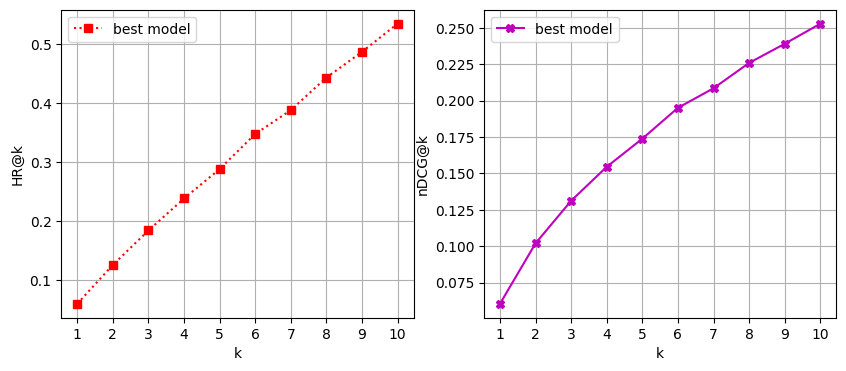

batch size: 512 - dropout: 0.5 - embedding dim: 16 - learning rate: 0.001 - num hiddens: 4 - weight decay: 1e-06


In [123]:
labels = ['best model']
visualize_eval_metrics([bm_hrs_at_k], [bm_ndcgs_at_k], labels, len(k_values), best_model['params'])

In [124]:
bm_metrics = display_eval_metrics([bm_hrs_at_k], [bm_ndcgs_at_k], ['Best model'], k_values)
bm_metrics

1         2         3         4         5         6   \
Best model HR@k    0.06051  0.126327  0.184713  0.238854  0.288747  0.348195   
           nDCG@k  0.06051  0.102036  0.131229  0.154546  0.173847  0.195023   

                         7         8         9         10  
Best model HR@k    0.388535  0.443737  0.487261  0.535032  
           nDCG@k  0.208470  0.225884  0.238986  0.252795

<a class='anchor' id='eval-embed-dims'></a>
### Through Embedding Dims

<div class='alert alert-block alert-info' style='font-weight: bold'>
    After manual observation, we decided to get the following set of hyperparameters to evaluate recommendation models through different embedding dims.
    <ul>
        <li>Batch size: 512</li>
        <li>Drop out rate: 0.5</li>
        <li>Learning rate: 1e-3</li>
        <li>Number of hidden layers: 3</li>
        <li>Weight decay: 1e-6</li>
    </ul>
    Embedding dim is in: [8, 16, 32]
</div>

In [125]:
picked_model_indices = [1, 2, 3]
picked_models = []
for x, idx in enumerate(picked_model_indices):
    picked_models.append(construct_model_dict(idx))
    print(picked_models[x]['params'])

(512, 0.5, 8, 0.001, 4, 1e-06)
(512, 0.5, 16, 0.001, 4, 1e-06)
(512, 0.5, 32, 0.001, 4, 1e-06)


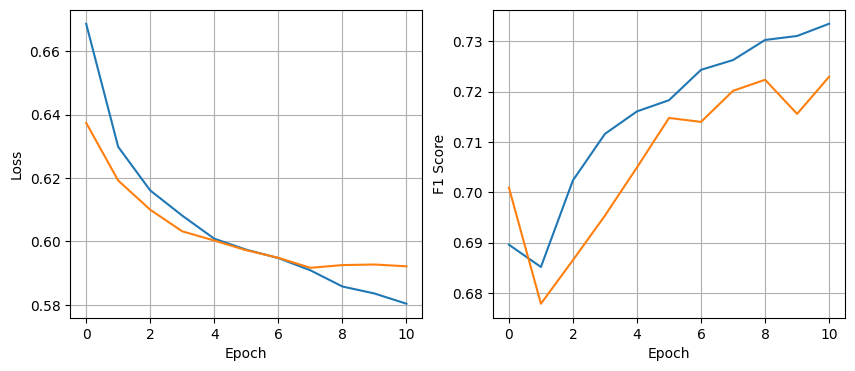

batch size: 512 - dropout: 0.5 - embedding dim: 8 - learning rate: 0.001 - num hiddens: 4 - weight decay: 1e-06



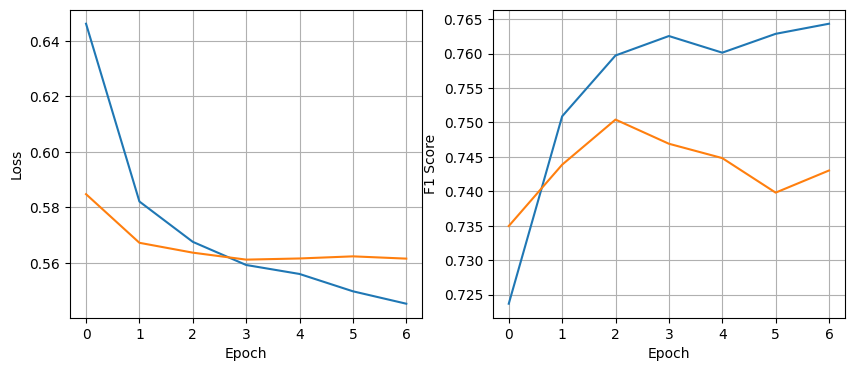

batch size: 512 - dropout: 0.5 - embedding dim: 16 - learning rate: 0.001 - num hiddens: 4 - weight decay: 1e-06



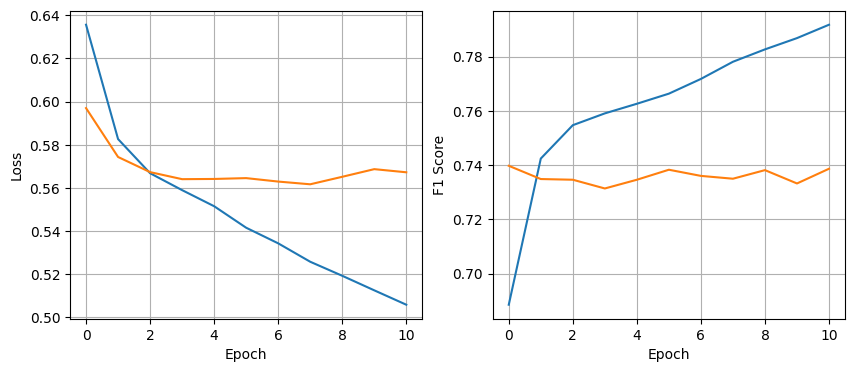

batch size: 512 - dropout: 0.5 - embedding dim: 32 - learning rate: 0.001 - num hiddens: 4 - weight decay: 1e-06



In [126]:
for model in picked_models:
    visualize_training(model['history'], model['params'])

In [127]:
emb_hrs_at_k = []
emb_ndcgs_at_k = []
for model in picked_models:
    hrs_at_k, ndcgs_at_k = evaluate_recommendation(model['model'], eval_data, df_ratings, k_values)
    emb_hrs_at_k.append(hrs_at_k)
    emb_ndcgs_at_k.append(ndcgs_at_k)

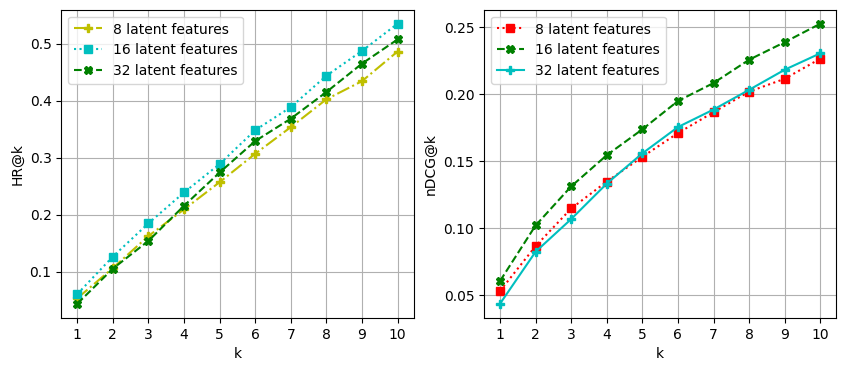

batch size: 512 - dropout: 0.5 - embedding dim: 8 - learning rate: 0.001 - num hiddens: 4 - weight decay: 1e-06


In [128]:
labels = [' '.join([str(dim), 'latent features']) for dim in embedding_dims]
visualize_eval_metrics(emb_hrs_at_k, emb_ndcgs_at_k, labels, len(k_values), picked_models[0]['params'])

In [129]:
emb_model_names = [f'Model-{dim}LF' for dim in embedding_dims]
emb_metrics = display_eval_metrics(emb_hrs_at_k, emb_ndcgs_at_k, emb_model_names, k_values)
emb_metrics

1         2         3         4         5         6   \
Model-8LF  HR@k    0.053079  0.106157  0.162420  0.209130  0.256900  0.306794   
           nDCG@k  0.053079  0.086567  0.114699  0.134816  0.153296  0.171068   
Model-16LF HR@k    0.060510  0.126327  0.184713  0.238854  0.288747  0.348195   
           nDCG@k  0.060510  0.102036  0.131229  0.154546  0.173847  0.195023   
Model-32LF HR@k    0.043524  0.105096  0.153928  0.215499  0.273885  0.329087   
           nDCG@k  0.043524  0.082371  0.106788  0.133305  0.155892  0.175555   

                         7         8         9         10  
Model-8LF  HR@k    0.353503  0.402335  0.434183  0.486200  
           nDCG@k  0.186638  0.202043  0.211630  0.226666  
Model-16LF HR@k    0.388535  0.443737  0.487261  0.535032  
           nDCG@k  0.208470  0.225884  0.238986  0.252795  
Model-32LF HR@k    0.368365  0.415074  0.464968  0.507431  
           nDCG@k  0.188648  0.203383  0.218402  0.230677

<a class='anchor' id='recommend'></a>
## *Process Recommendation*

In [56]:
def get_user_rating_history(user_id):
    
    rt_hist = df_ratings[df_ratings['user_id'] == user_id].sort_values(by=['rating', 'timestamp'], ascending=False)
    rt_hist['title'] = rt_hist.apply(lambda row: df_movies[df_movies['movie_id'] == row['movie_id']].iloc[0]['title'], axis=1)
    
    return rt_hist

In [102]:
def recommend(model, user_id, n_movies=10, include_watched=True):
    
    rel_scores = predict_relevant_scores(model, user_id, list(range(0, general_info['items'])))
    desc_rel_scores = rel_scores.sort(descending=True)
    
    recommended_movies = []
    counts = 0
    for i, idx in enumerate(desc_rel_scores[1]):
            
        original_rating = df_ratings[(df_ratings['user_id'] == user_id) & (df_ratings['movie_id'] == int(idx))]
        if len(original_rating) > 0:
            original_rating = original_rating['rating'].iloc[0]
            if not include_watched:
                continue
        else:    
            original_rating = float('nan')
                
        recommended_movies.append((int(idx), df_movies['title'].iloc[int(idx)], original_rating, desc_rel_scores[0][i].item()))
        counts += 1
        if counts == n_movies:
            return recommended_movies
    
    return recommended_movies

In [103]:
ex_user_id = random.randint(0, general_info['users'] - 1)
n_movies = 10
include_watched = True
recommender = best_model['model']

In [104]:
recommended_movies = recommend(recommender, ex_user_id, n_movies, include_watched)
print(f'=' * 16)
print(f'User ID: {ex_user_id}')
print(f'=' * 16)
df_rec = pd.DataFrame(recommended_movies, columns=['movie_id', 'title', 'rating', 'relevant_score'])
df_rec

User ID: 381


,movie_id,title,rating,relevant_score
0,1491,Window to Paris (1994),NaN,0.743709
1,1063,Crossfire (1947),NaN,0.727869
2,1124,"Innocents, The (1961)",NaN,0.721675
3,1018,"Die xue shuang xiong (Killer, The) (1989)",NaN,0.719617
4,113,Wallace & Gromit: The Best of Aardman Animatio...,NaN,0.696380
5,1168,Fresh (1994),NaN,0.696215
6,1498,Grosse Fatigue (1994),NaN,0.684906
7,407,"Close Shave, A (1995)",NaN,0.679101
8,1505,Nelly & Monsieur Arnaud (1995),NaN,0.669683
9,95,Terminator 2: Judgment Day (1991),NaN,0.668025


In [106]:
get_user_rating_history(ex_user_id).head(n_movies)

,user_id,movie_id,rating,timestamp,title
62999,381,333,5,876802971,U Turn (1997)
88495,381,1267,5,875947296,Bitter Moon (1992)
15398,381,1228,5,875947240,Poison Ivy II (1995)
11528,381,473,5,875947199,Dr. Strangelove or: How I Learned to Stop Worr...
18642,381,480,5,875947078,"Apartment, The (1960)"
76762,381,58,5,875947049,Three Colors: Red (1994)
54379,381,22,5,875946978,Taxi Driver (1976)
62128,381,481,5,875946945,Some Like It Hot (1959)
26521,381,55,5,875946830,Pulp Fiction (1994)
27611,381,179,5,875946830,Apocalypse Now (1979)
